## 1- Configurações Iniciais

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import statsmodels.api as sm

In [3]:
#mostrar todas as colunas do dataframe
pd.set_option('display.max_columns', None)

#evitar números em notação científica
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

In [4]:
#random_state
SEED = 42

#proporção de base de teste e treino
TEST_SIZE = 0.2

#probabilidade limite de ocorrência de evento
LIMIAR = 0.5

#parâmetro de calibragem do FScore
BETA = 2

In [8]:
df = pd.read_excel('Dataset.xlsx')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## 2 - EDA

### 2.1 - Avaliação preliminar

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Não há que se preocupar com valores nulos.

In [9]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,36.92,802.49,9.19,2.91,1.00,1024.87,2.72,65.89,2.73,2.06,2.73,6502.93,14313.10,2.69,15.21,3.15,2.71,80.00,0.79,11.28,2.80,2.76,7.01,4.23,2.19,4.12
std,9.14,403.51,8.11,1.02,0.00,602.02,1.09,20.33,0.71,1.11,1.10,4707.96,7117.79,2.50,3.66,0.36,1.08,0.00,0.85,7.78,1.29,0.71,6.13,3.62,3.22,3.57
min,18.00,102.00,1.00,1.00,1.00,1.00,1.00,30.00,1.00,1.00,1.00,1009.00,2094.00,0.00,11.00,3.00,1.00,80.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,30.00,465.00,2.00,2.00,1.00,491.25,2.00,48.00,2.00,1.00,2.00,2911.00,8047.00,1.00,12.00,3.00,2.00,80.00,0.00,6.00,2.00,2.00,3.00,2.00,0.00,2.00
50%,36.00,802.00,7.00,3.00,1.00,1020.50,3.00,66.00,3.00,2.00,3.00,4919.00,14235.50,2.00,14.00,3.00,3.00,80.00,1.00,10.00,3.00,3.00,5.00,3.00,1.00,3.00
75%,43.00,1157.00,14.00,4.00,1.00,1555.75,4.00,83.75,3.00,3.00,4.00,8379.00,20461.50,4.00,18.00,3.00,4.00,80.00,1.00,15.00,3.00,3.00,9.00,7.00,3.00,7.00
max,60.00,1499.00,29.00,5.00,1.00,2068.00,4.00,100.00,4.00,5.00,4.00,19999.00,26999.00,9.00,25.00,4.00,4.00,80.00,3.00,40.00,6.00,4.00,40.00,18.00,15.00,17.00


In [10]:
#removendo colunas constantes: StandardHours, EmployeeCount e Over18
print(df['StandardHours'].unique())
print(df['EmployeeCount'].unique())
print(df['Over18'].unique())

df.drop(columns=['StandardHours','EmployeeCount','Over18'], inplace=True)

[80]
[1]
['Y']


In [11]:
#tranformando o 'Attrition' em inteiros
dict_attrition = {'Yes':1, 'No':0}
df['Attrition'] = df['Attrition'].apply(lambda x: dict_attrition[x])

0    1233
1     237
Name: Attrition, dtype: int64


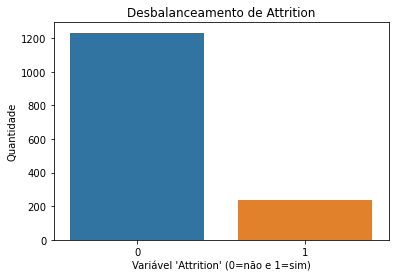

In [13]:
#avaliando o desbalanceamento do 'Attrition'
print(df['Attrition'].value_counts())
fig = sns.countplot(x = 'Attrition', data=df, order=[0,1])
fig.set_xlabel("Variável 'Attrition' (0=não e 1=sim)")
fig.set_ylabel('Quantidade')
fig.set_title('Desbalanceamento de Attrition')
plt.savefig(fname='desbal_attrition', dpi=200)
plt.show()

A base aponta um desbalanceamento de 6:1 para Attrition, o que pode ser um problema durante a avaliação de métricas de modelos.

### 2.2 - Avaliação de correlação

In [15]:
#selecionando as variáveis categóricas e variáveis numéricas
df_cat = df.loc[:,df.dtypes == np.object]
df_num = df.loc[:,df.dtypes == np.int]
df_num.drop(columns='Attrition', inplace=True)

/home/rafaelk/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


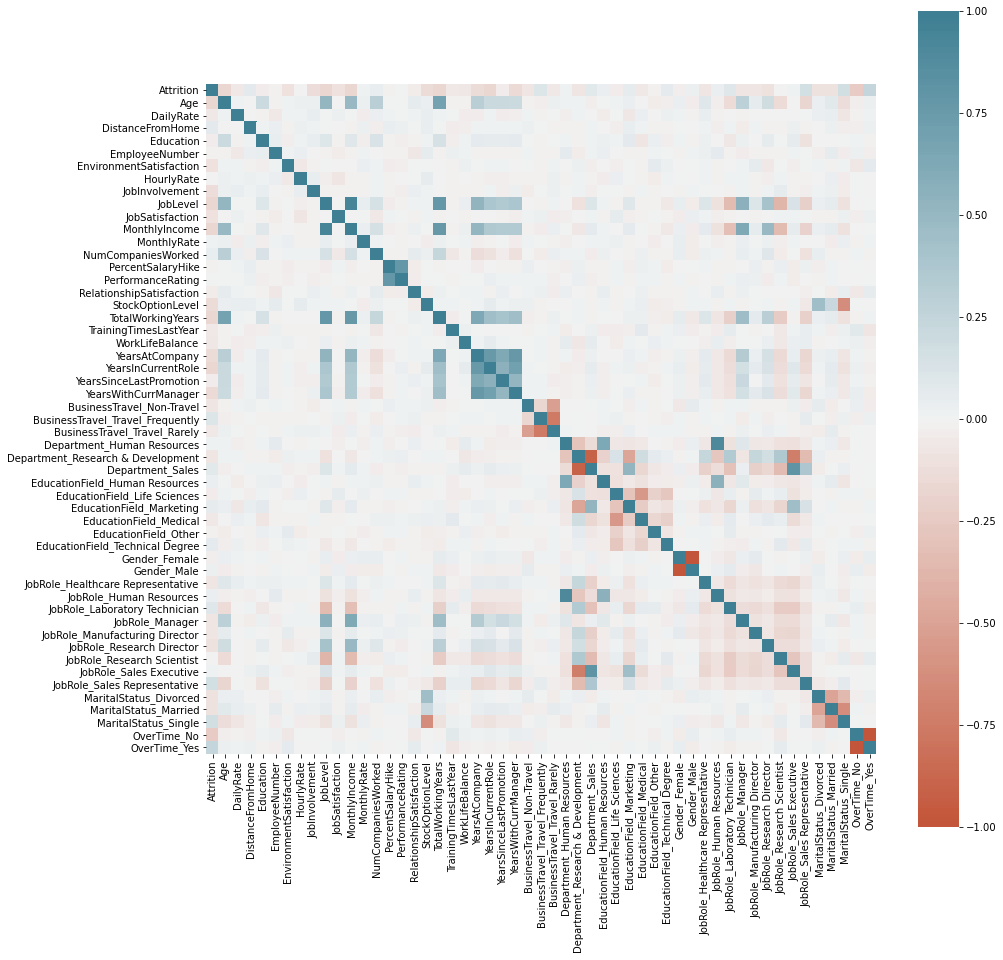

In [16]:
#Avaliação das correlações

#criando dummies com todas as categorias
i = pd.get_dummies(df_cat, drop_first=False)
df_dummies_todas = pd.concat([df['Attrition'],df_num, i], axis=1)

#mapa de calor
corr = df_dummies_todas.corr()
plt.subplots(figsize=(15,15)) 
grafico_corr = sns.heatmap(corr 
                           , vmin=-1
                           , vmax=1
                           , center=0
                           , cmap=sns.diverging_palette(20, 220, n=200)
                           , square=True
                           )

/home/rafaelk/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


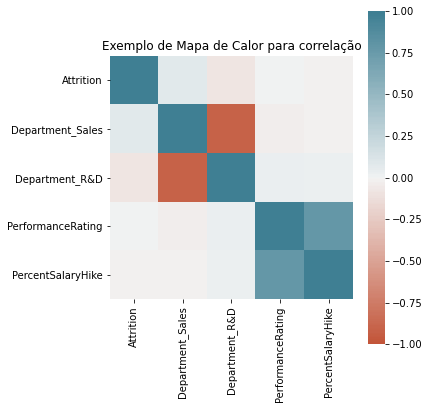

In [17]:
#exemplo de mapal de correlação para os slides
df_ppt = df_dummies_todas[['Attrition'
                           ,'Department_Sales'
                           ,'Department_Research & Development'
                           ,'PerformanceRating'
                           ,'PercentSalaryHike'
                          ]]
df_ppt.rename(columns={'Department_Research & Development':'Department_R&D'}, inplace=True)

plt.subplots(figsize=(6,6)) 
fig = sns.heatmap(df_ppt.corr() 
                   , vmin=-1
                   , vmax=1
                   , center=0
                   , cmap=sns.diverging_palette(20, 220, n=200)
                   , square=True
                   )
plt.title('Exemplo de Mapa de Calor para correlação')
plt.tight_layout()
plt.savefig(fname='corr_map', dpi=500)
plt.show()

In [19]:
#avaliação detalhada de correlação: variáveis de tempo de carreira
var_corr_tempo = ['Age'
                 ,'TotalWorkingYears'
                 ,'JobLevel'
                 ,'MonthlyIncome'
                 ,'YearsAtCompany'
                 ,'YearsInCurrentRole'
                 ,'YearsSinceLastPromotion'
                 ,'YearsWithCurrManager'
                ]
df_dummies_todas[var_corr_tempo].corr()

,Age,TotalWorkingYears,JobLevel,MonthlyIncome,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.00,0.68,0.51,0.50,0.31,0.21,0.22,0.20
TotalWorkingYears,0.68,1.00,0.78,0.77,0.63,0.46,0.40,0.46
JobLevel,0.51,0.78,1.00,0.95,0.53,0.39,0.35,0.38
MonthlyIncome,0.50,0.77,0.95,1.00,0.51,0.36,0.34,0.34
YearsAtCompany,0.31,0.63,0.53,0.51,1.00,0.76,0.62,0.77
YearsInCurrentRole,0.21,0.46,0.39,0.36,0.76,1.00,0.55,0.71
YearsSinceLastPromotion,0.22,0.40,0.35,0.34,0.62,0.55,1.00,0.51
YearsWithCurrManager,0.20,0.46,0.38,0.34,0.77,0.71,0.51,1.00


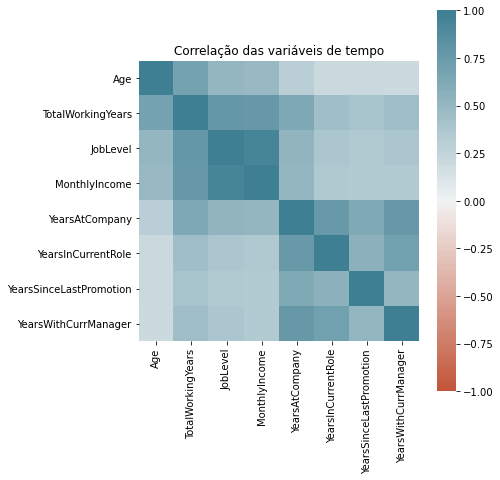

In [20]:
#mapa de calor para correlação entre variáveis de tempo de carreira
plt.subplots(figsize=(7,7)) 
fig = sns.heatmap(df_dummies_todas[var_corr_tempo].corr()
                   , vmin=-1
                   , vmax=1
                   , center=0
                   , cmap=sns.diverging_palette(20, 220, n=200)
                   , square=True
                   )
plt.title('Correlação das variáveis de tempo')
plt.tight_layout()
plt.savefig(fname='corr_map_tempo', dpi=500)
plt.show()

In [21]:
#avaliação detalhada de correlação entre as variáveis de promoção
var_corr_promocao = ['Attrition'
                     ,'PercentSalaryHike'
                     ,'PerformanceRating'
                    ]
                    
df_dummies_todas[var_corr_promocao].corr()

,Attrition,PercentSalaryHike,PerformanceRating
Attrition,1.00,-0.01,0.00
PercentSalaryHike,-0.01,1.00,0.77
PerformanceRating,0.00,0.77,1.00


In [22]:
#avaliação detalhada de correlação entre as variáveis de cargo
var_corr_cargo = ['Attrition'
                  ,'JobRole_Healthcare Representative'
                  ,'JobRole_Human Resources'
                  ,'JobRole_Laboratory Technician'
                  ,'JobRole_Manager'
                  ,'JobRole_Manufacturing Director'
                  ,'JobRole_Research Director'
                  ,'JobRole_Research Scientist'
                  ,'JobRole_Sales Executive'
                  ,'JobRole_Sales Representative'
                  ,'JobInvolvement'
                  ,'JobLevel'
                  ,'JobSatisfaction'
                  ,'EnvironmentSatisfaction'
                  ,'WorkLifeBalance'
                 ]    
                        
df_dummies_todas[var_corr_cargo].corr()

,Attrition,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobInvolvement,JobLevel,JobSatisfaction,EnvironmentSatisfaction,WorkLifeBalance
Attrition,1.00,-0.08,0.04,0.10,-0.08,-0.08,-0.09,-0.00,0.02,0.16,-0.13,-0.17,-0.10,-0.10,-0.06
JobRole_Healthcare Representative,-0.08,1.00,-0.06,-0.14,-0.09,-0.10,-0.08,-0.16,-0.17,-0.08,0.00,0.12,0.02,0.01,-0.03
JobRole_Human Resources,0.04,-0.06,1.00,-0.09,-0.05,-0.06,-0.05,-0.10,-0.10,-0.05,-0.00,-0.10,-0.03,-0.02,0.04
JobRole_Laboratory Technician,0.10,-0.14,-0.09,1.00,-0.13,-0.15,-0.11,-0.23,-0.25,-0.11,-0.02,-0.34,-0.02,-0.00,-0.03
JobRole_Manager,-0.08,-0.09,-0.05,-0.13,1.00,-0.09,-0.07,-0.14,-0.15,-0.07,0.02,0.55,-0.01,0.01,0.01
JobRole_Manufacturing Director,-0.08,-0.10,-0.06,-0.15,-0.09,1.00,-0.08,-0.16,-0.18,-0.08,-0.02,0.11,-0.01,0.06,0.00
JobRole_Research Director,-0.09,-0.08,-0.05,-0.11,-0.07,-0.08,1.00,-0.12,-0.13,-0.06,0.02,0.41,-0.01,-0.05,0.03
JobRole_Research Scientist,-0.00,-0.16,-0.10,-0.23,-0.14,-0.16,-0.12,1.00,-0.27,-0.12,0.05,-0.39,0.02,0.00,-0.06
JobRole_Sales Executive,0.02,-0.17,-0.10,-0.25,-0.15,-0.18,-0.13,-0.27,1.00,-0.13,-0.01,0.13,0.01,-0.02,0.03
JobRole_Sales Representative,0.16,-0.08,-0.05,-0.11,-0.07,-0.08,-0.06,-0.12,-0.13,1.00,-0.03,-0.22,0.00,0.00,0.05


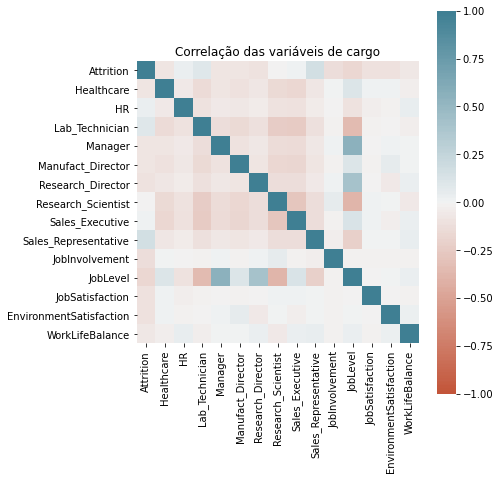

In [24]:
#mapa de calor para correlação entre variáveis de cargo
df_cargo_ppt = df_dummies_todas[var_corr_cargo]
df_cargo_ppt.rename(columns={'JobRole_Healthcare Representative':'Healthcare'
                              ,'JobRole_Human Resources': 'HR'
                              ,'JobRole_Laboratory Technician':'Lab_Technician'
                              ,'JobRole_Manager':'Manager'
                              ,'JobRole_Manufacturing Director':'Manufact_Director'
                              ,'JobRole_Research Director':'Research_Director'
                              ,'JobRole_Research Scientist':'Research_Scientist'
                              ,'JobRole_Sales Executive':'Sales_Executive'
                              ,'JobRole_Sales Representative':'Sales_Representative'
                              }, inplace=True)

plt.subplots(figsize=(7,7)) 
fig = sns.heatmap(df_cargo_ppt.corr()
                   , vmin=-1
                   , vmax=1
                   , center=0
                   , cmap=sns.diverging_palette(20, 220, n=200)
                   , square=True
                   )
plt.title('Correlação das variáveis de cargo')
plt.tight_layout()
plt.savefig(fname='corr_map_cargo', dpi=500)
plt.show()

Conclusões:
* Variáveis temporais Age, TotalWorkingYears, JobLevel, YearsAtCompany, YearsInCurrentRole, YearsSunceLastPromotion, YearsWithCurrManager apresentam considerável correlação entre si;
* Variáveis de promoção PercentSalaryHike e PerformanceRating apresentam alta correlação entre si (77%);
* Variáveis de cargo apresentam baixa correlação entre si no geral, além de correlações específicas esperadas, como JobLevel e cargos de gerência e diretoria (62% e 49%).

### 2.3 - Avaliação Boxplot

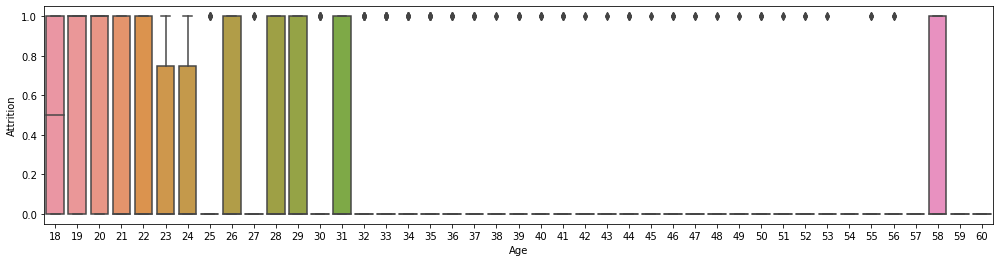

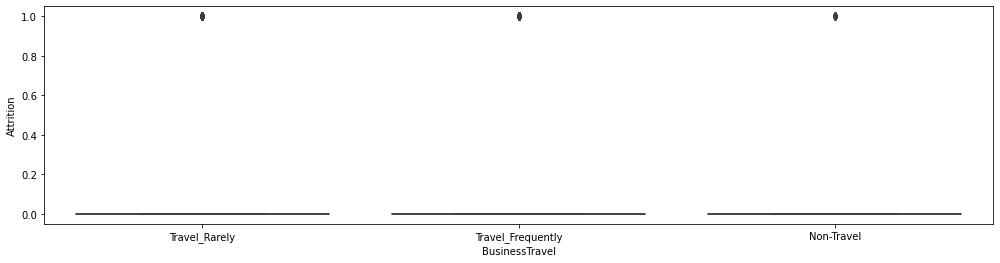

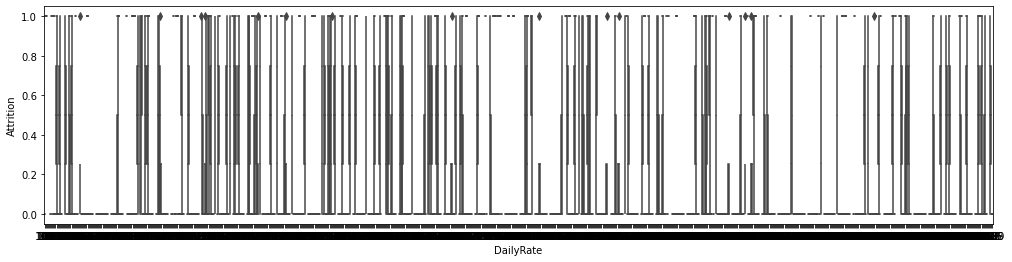

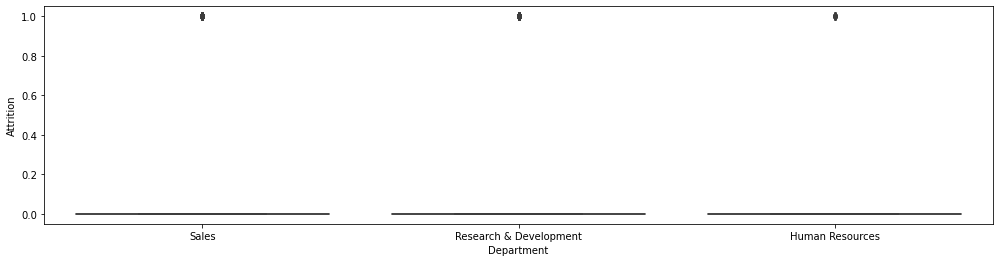

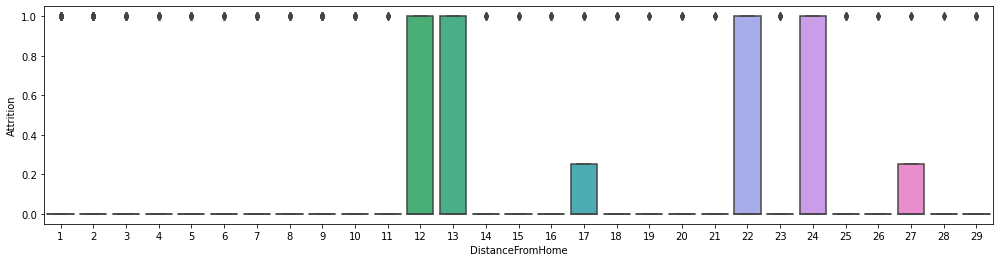

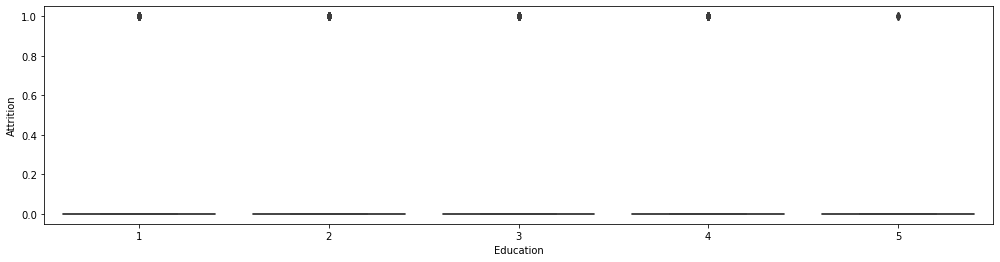

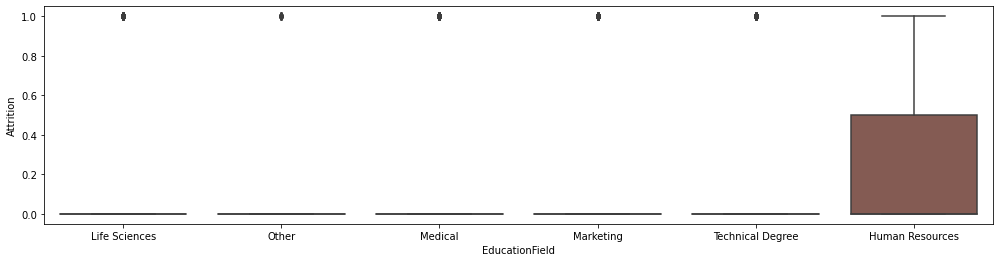

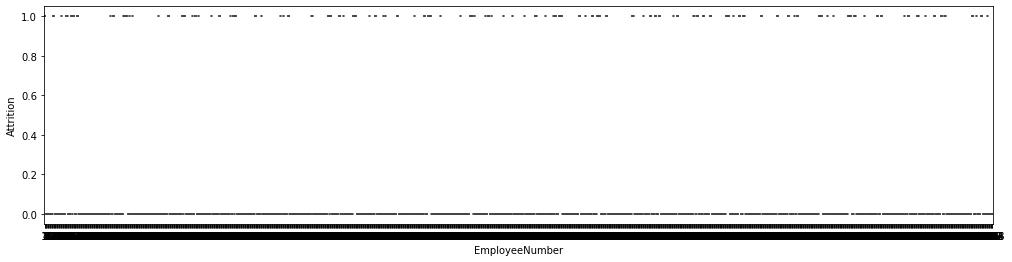

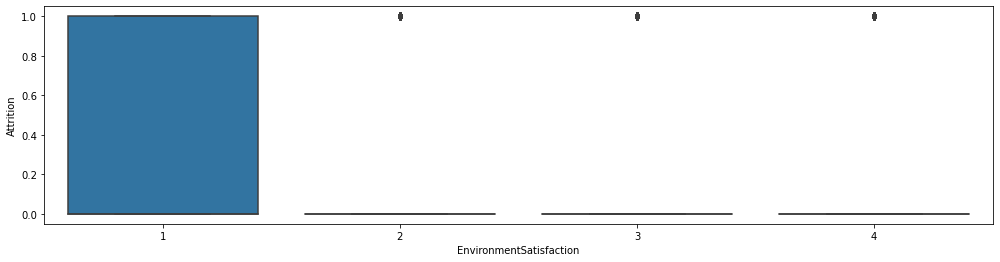

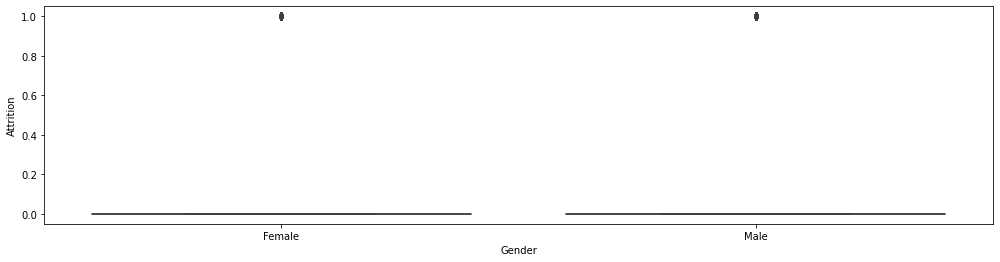

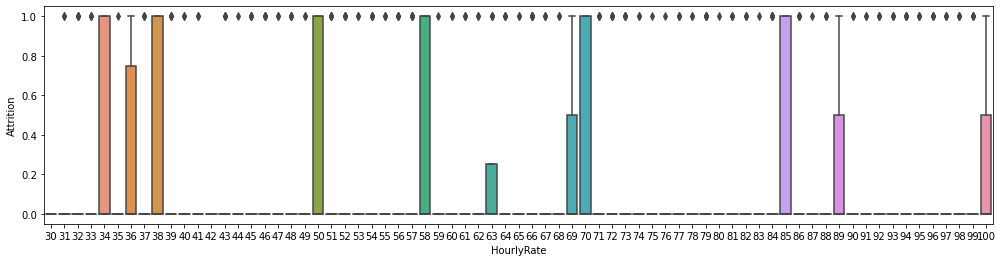

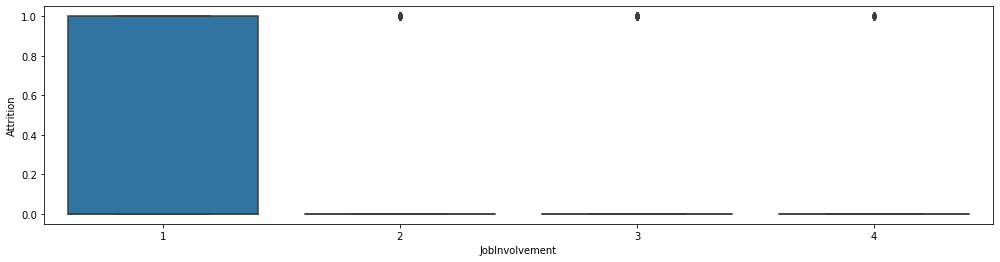

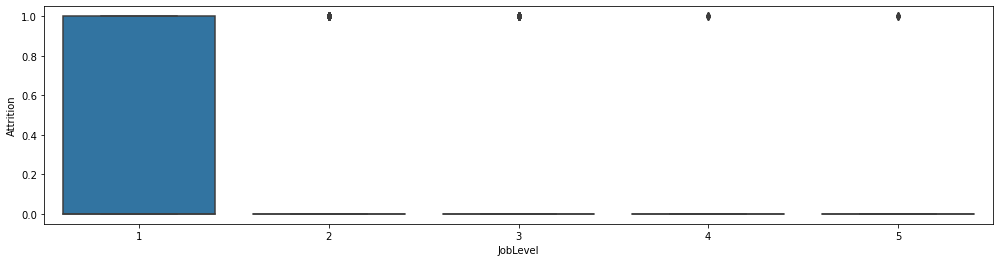

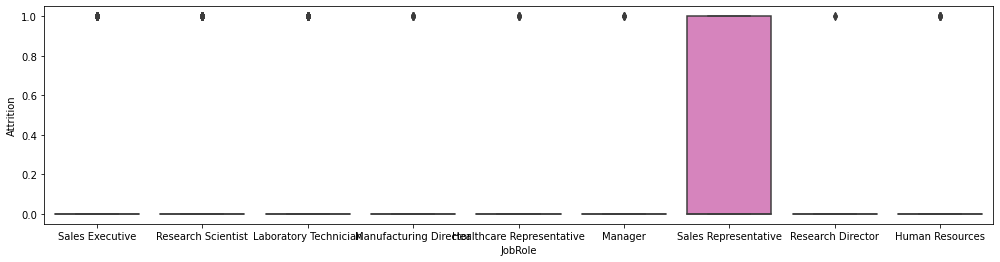

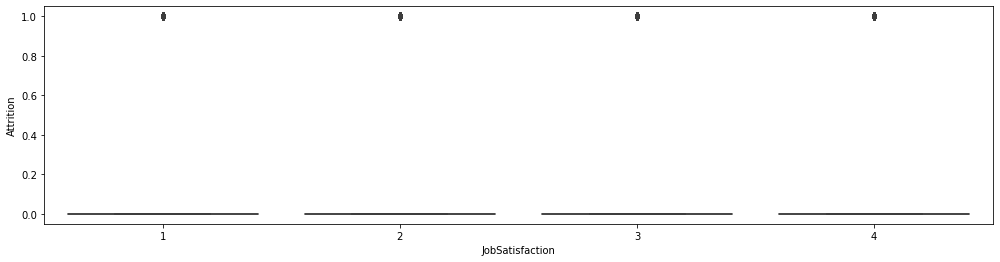

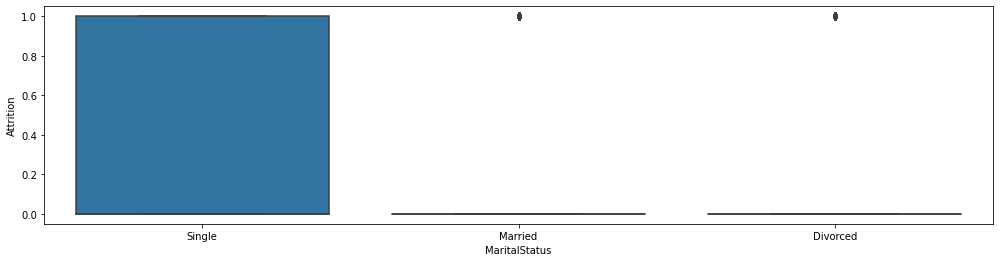

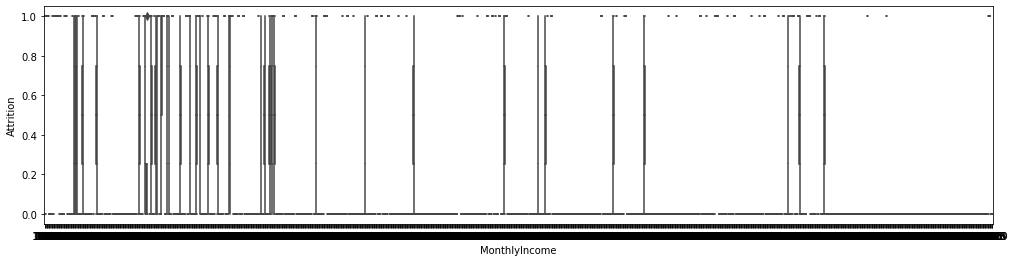

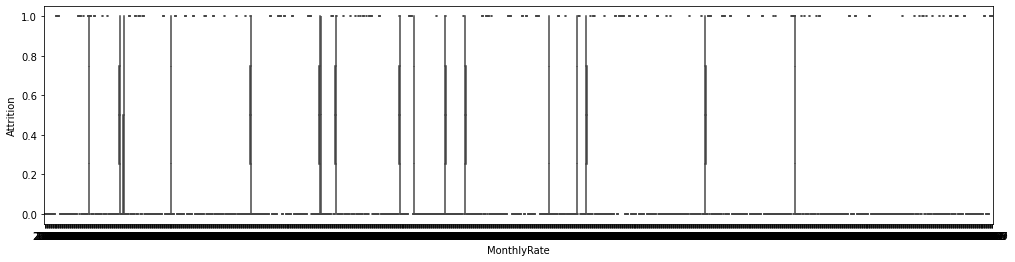

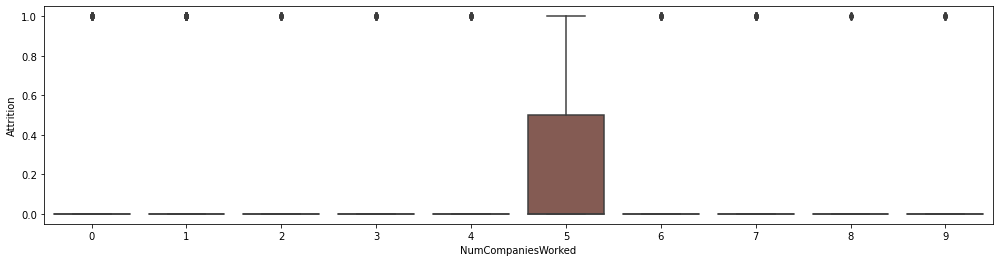

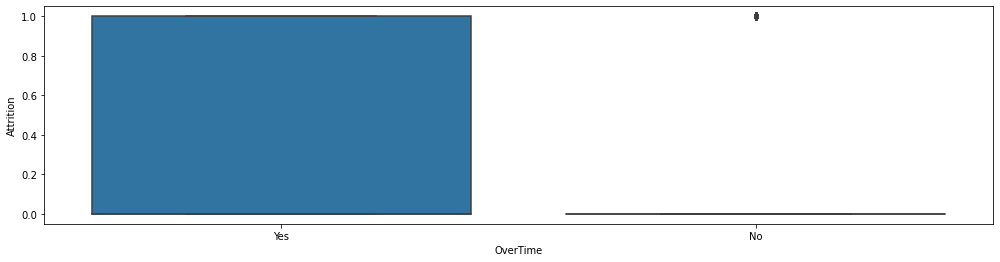

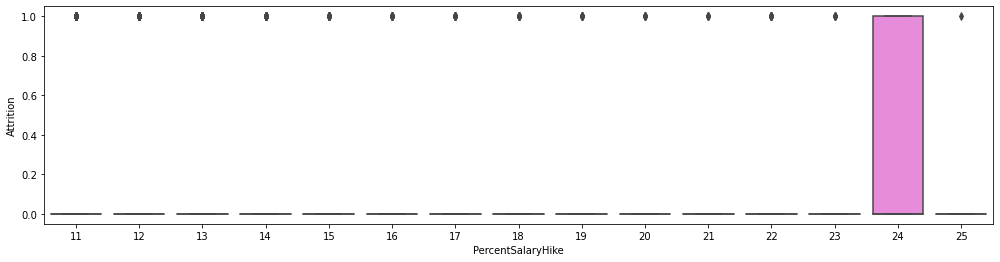

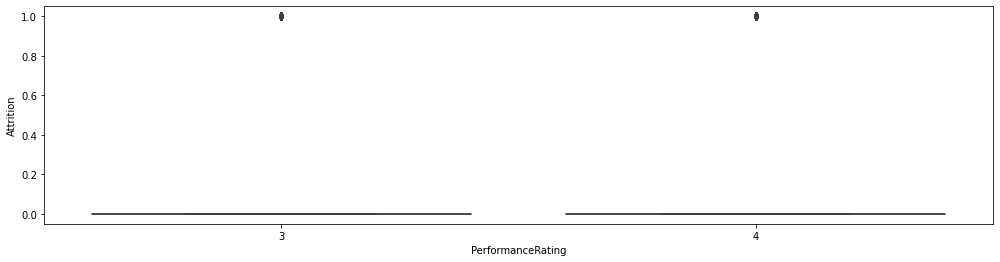

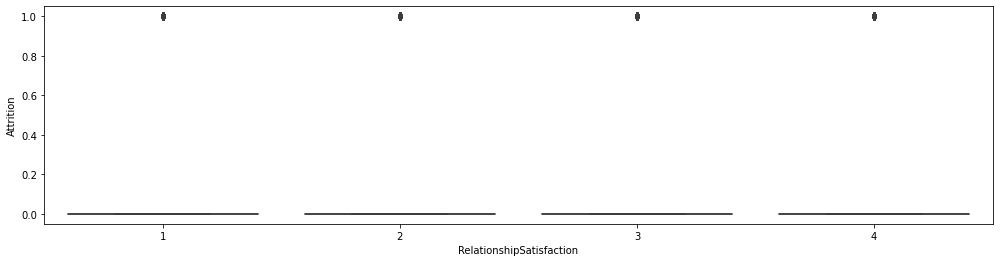

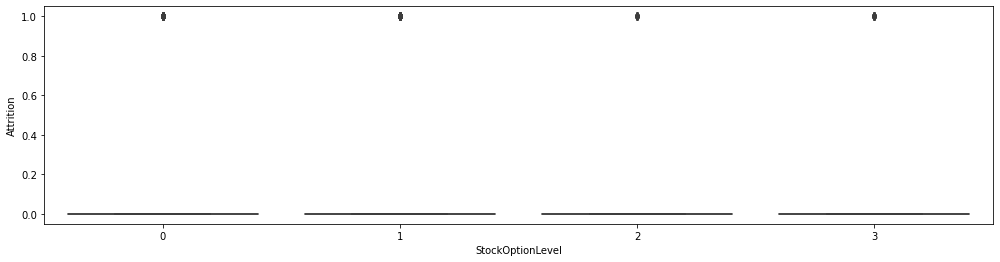

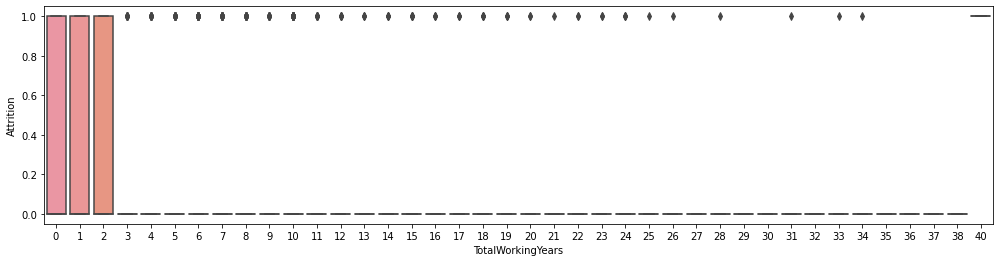

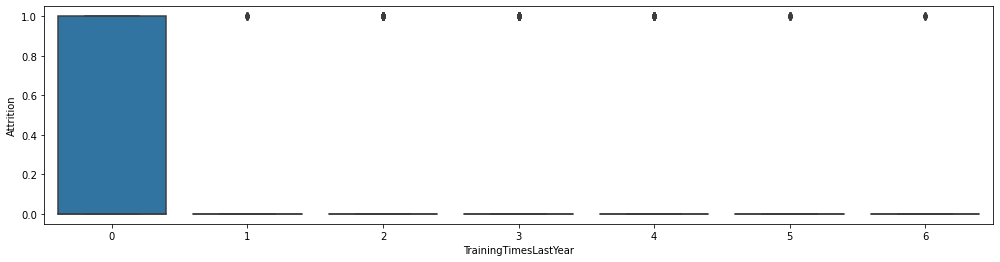

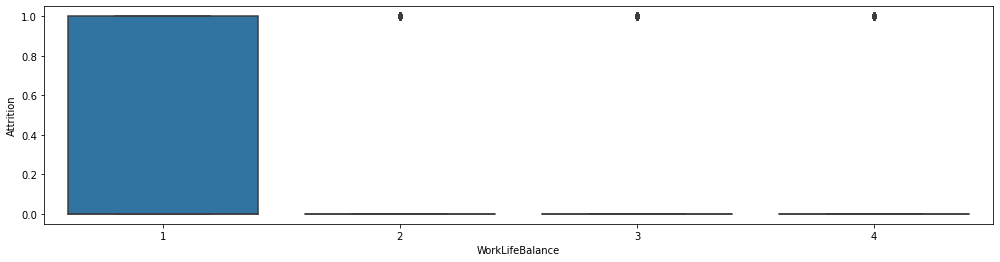

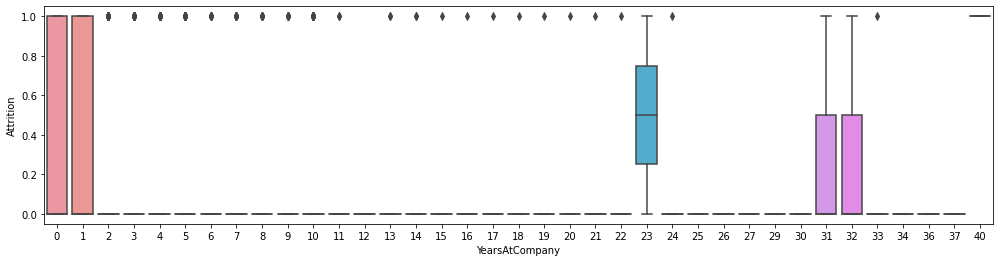

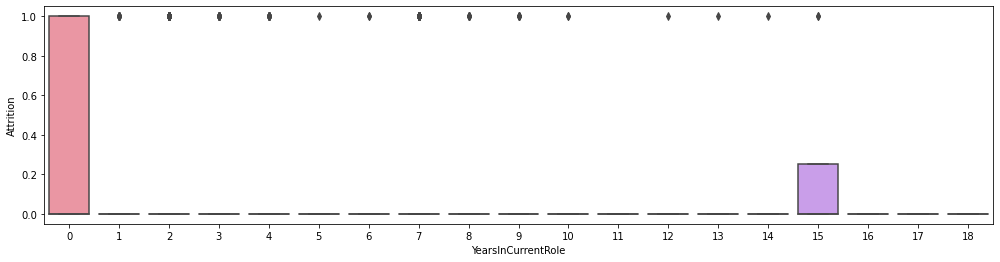

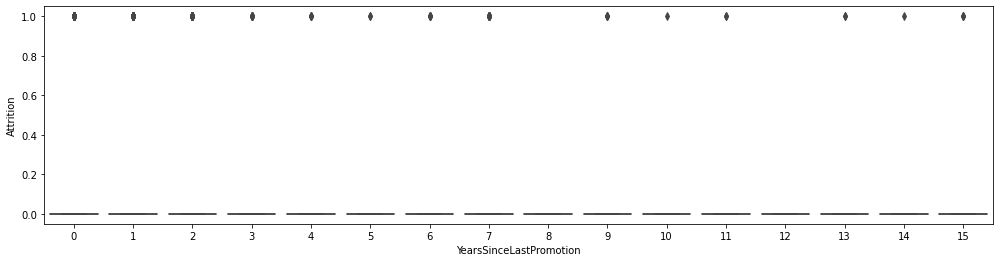

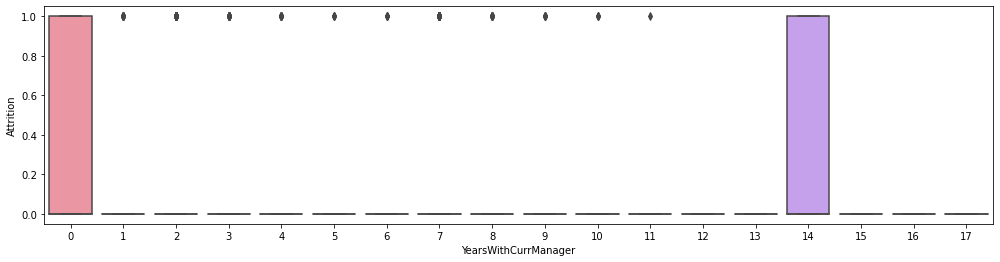

In [27]:
#boxplot das variáveis categóricas
for i in df.drop(columns='Attrition').columns:
    plt.subplots(figsize=(17,4))
    fig = sns.boxplot(x=i, y='Attrition', data=df)
    plt.show()

##### Variáveis promissoras:

* Categóricas
    * EducationField : Human Resources
    * JobRole: Sales Representative
    * MaritalStatus: Single
    * OverTime: Yes


* Numéricas
    * Age
    * DistanceFromHome
    * EnvironmentSatisfaction
    * HourlyRate
    * JobInvolvement
    * JobLevel
    * NumCompaniesWorked
    * PercentSalaryHike
    * TotalWorkingYears
    * TrainingTimesLastYear
    * WorkLifeBalance
    * YearsAtCompany
    * YearsInCurrentRole
    * YearsWithCurrManager

### 2.4 - Histogramas

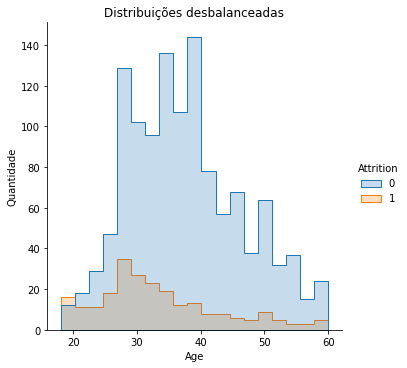

In [29]:
#exemplo de histograma desbalanceado (slide)

i = 'Age'

fig = sns.displot(data=df
                   , x='Age'
                   , hue='Attrition'
                   , element='step'
                   #, stat='density'                     
                   #, common_norm=False
                   )
fig.set(title=f'Distribuições desbalanceadas', xlabel=i, ylabel='Quantidade')
fig.savefig(f'hist_{i}_desbalanceado')

/home/rafaelk/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


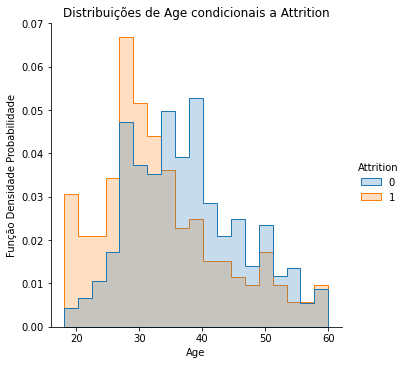

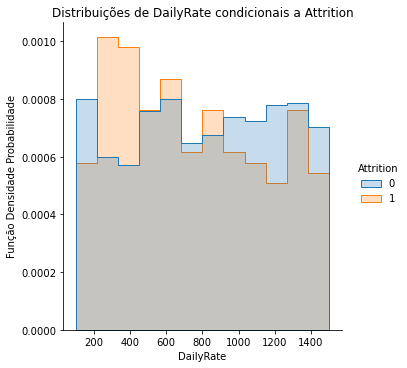

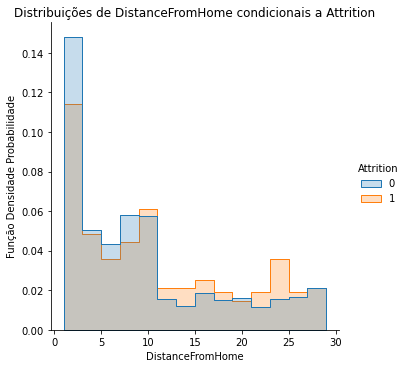

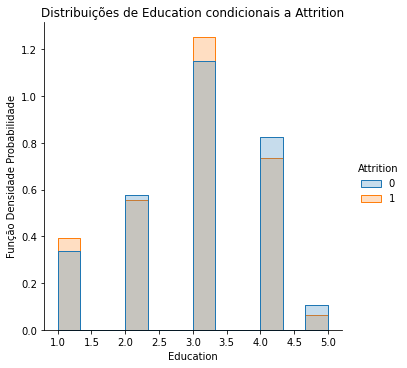

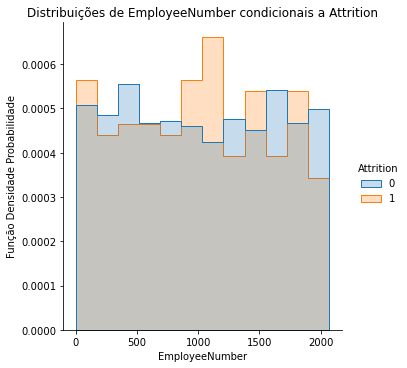

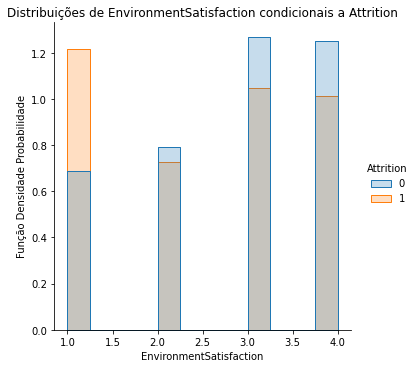

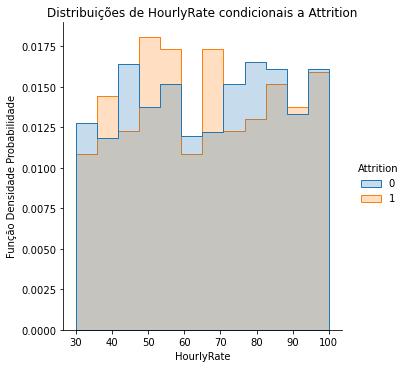

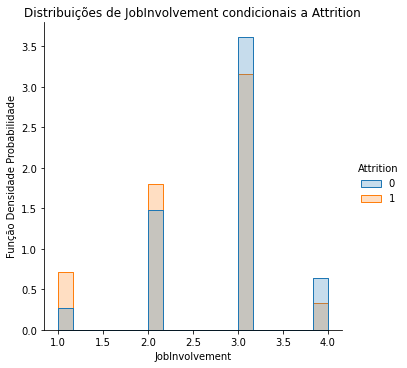

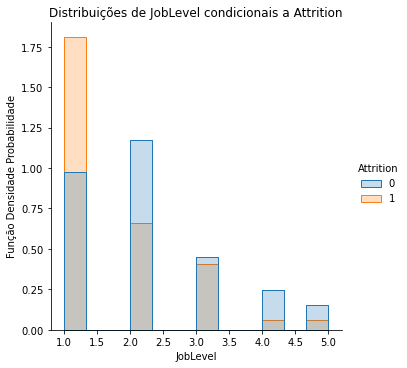

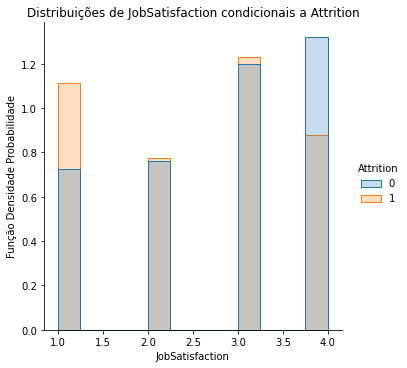

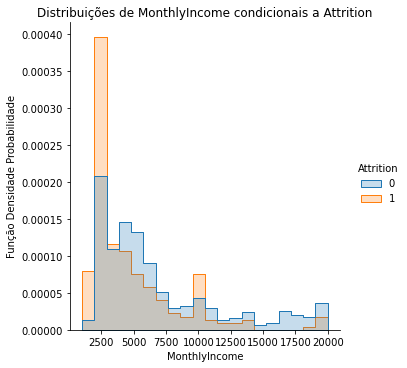

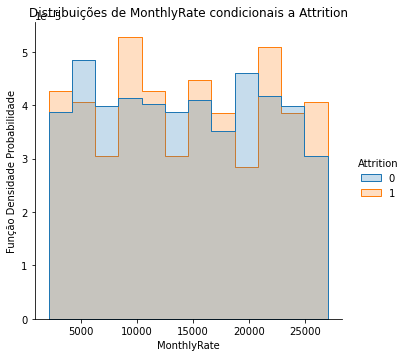

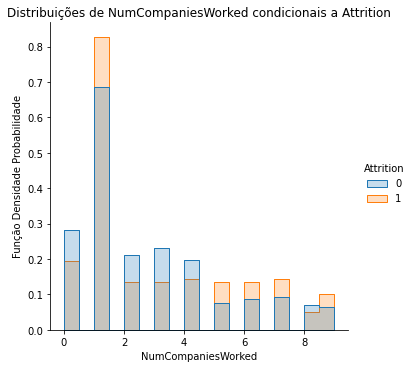

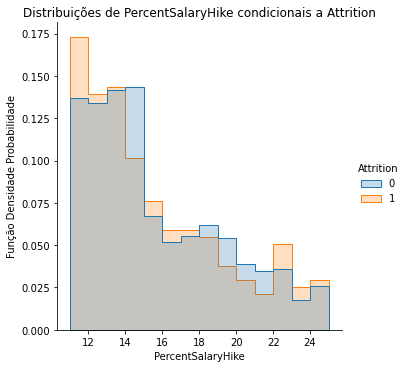

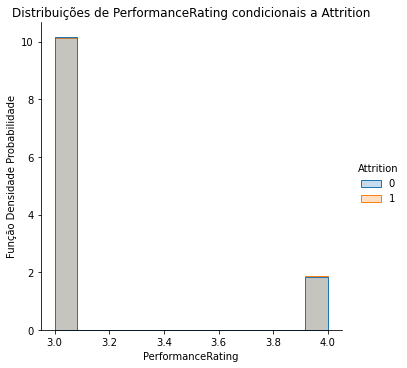

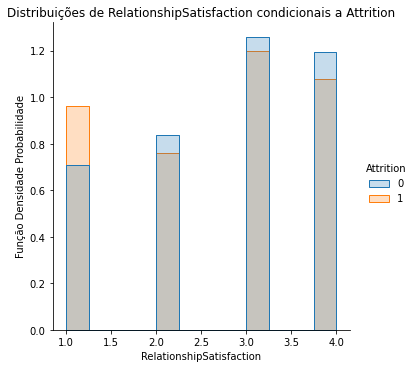

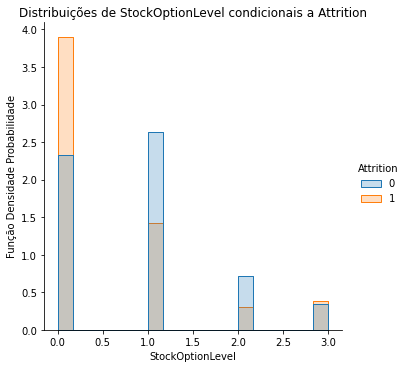

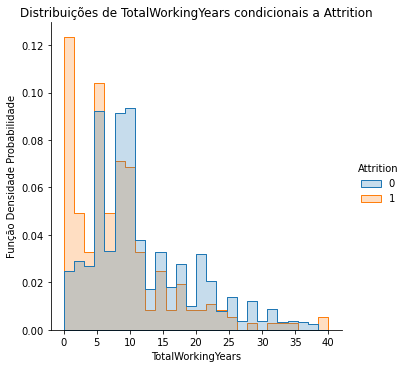

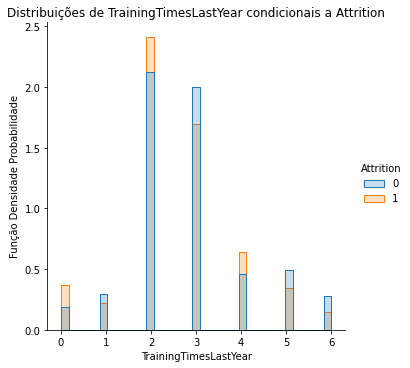

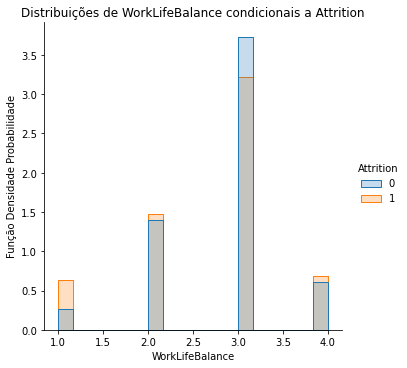

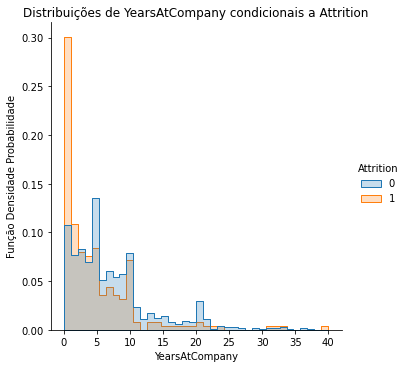

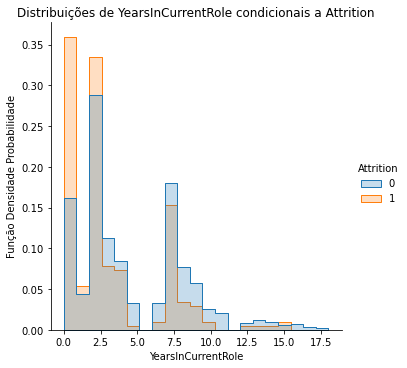

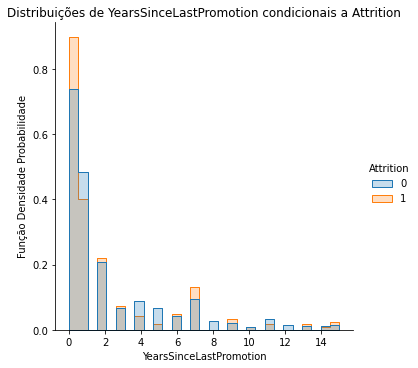

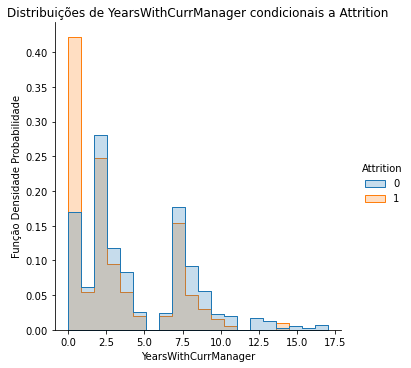

In [26]:
#histograma das variáveis numéricas
for i in df_num.columns:
    fig = sns.displot(data=df
                       , x=i
                       , hue='Attrition'
                       , element='step'
                       #normalizador do número de amostra 
                       , stat='density'                     
                       , common_norm=False
                       )
    fig.set(title=f'Distribuições de {i} condicionais a Attrition', xlabel=i, ylabel='Função Densidade Probabilidade')
    fig.savefig(f'hist_{i}')

Dado que 'Attrition' é uma variável desbalanceada, os histogramas acima foram criados considerado a proporção das bases, de modo a permitir uma melhor comparação.

Os histogramas indicam distribuições desiguais em relação a 'Age',
'EnvironmentSatisfaction','JobLevel', 'JobSatisfaction', 'StockOptionLevel','TotalWorkingYears'
'YearsAtCompany' e 'YearsWithCurrManager'.

Contudo, é importante considerar a ressalva de que as conclusões dos histogramas são altamente sensíveis a parâmetros, como quantidade e largura de colunas, portanto, não devem ser avaliados exclusivamente. 

In [30]:
def qqplot(var):
    '''
    Plot manual do qqplot comparando a distribuição da variável em questão
    condicional a 'Attrition'.
    
    Interpretação do gráfico: quanto mais distante da linha diagonal, mais
    diferentes são as distribuições
    '''
    
    X_100 = []
    Y_100 = []
    
    #series da variável condicional ao 'Attrition'
    X_series = df[df['Attrition'] == 0][var]
    Y_series = df[df['Attrition'] == 1][var]
    
    #criando a lista dos percentis de 1 a 100
    for i in range(101):
        X_100.append(np.percentile(X_series,i))
        Y_100.append(np.percentile(Y_series,i))
    
    #linha diagonal
    plt.plot([X_100[0], X_100[100]], [Y_100[0], Y_100[100]], 'k-', lw=2)
    
    #qqplot
    plt.scatter(X_100, Y_100)
    plt.grid()
    plt.title(f'QQPlot de {var}')
    plt.ylabel(f'Distribuição ({var}|Attrition = 0)')
    plt.xlabel(f'Distribuição ({var}|Attrition = 1)')
    plt.tight_layout()
    plt.savefig(fname=f'qqplot_{var}', dpi=500)
    plt.show()

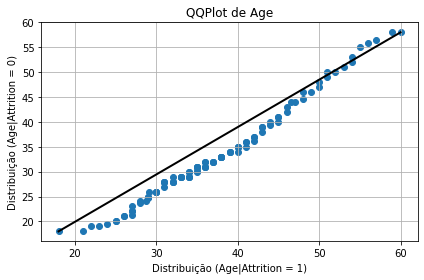

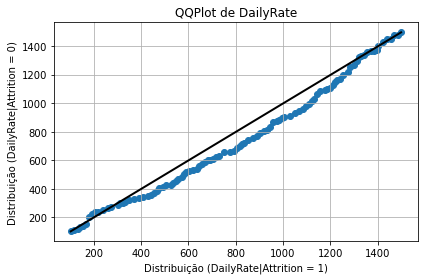

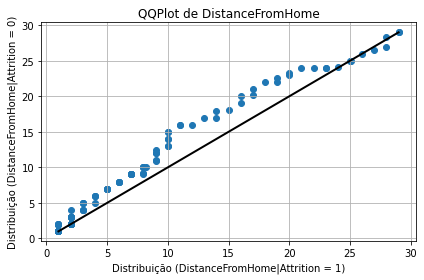

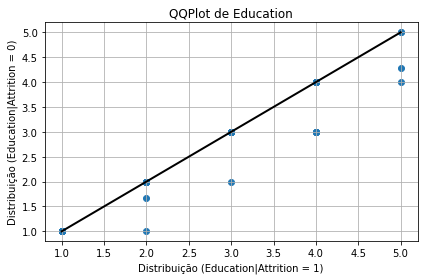

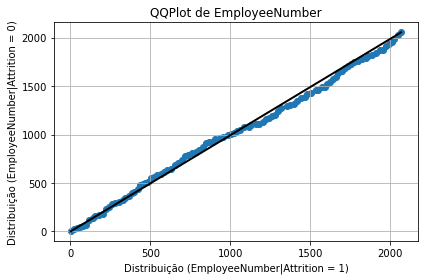

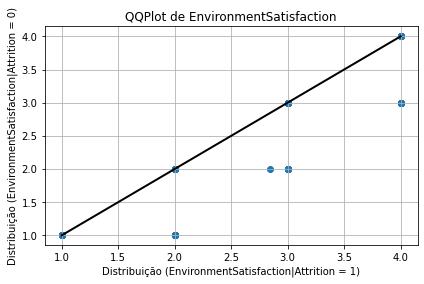

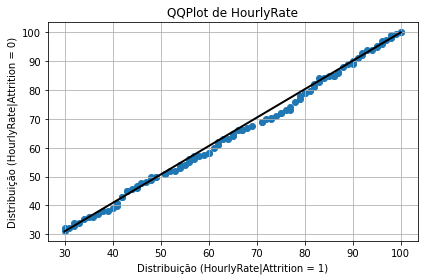

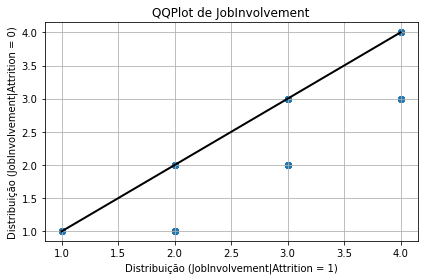

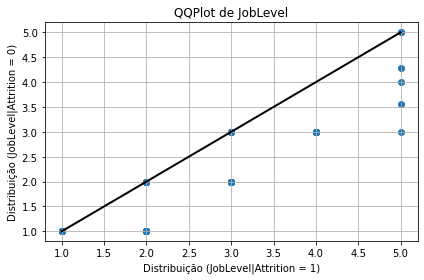

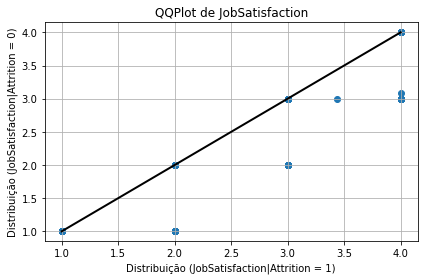

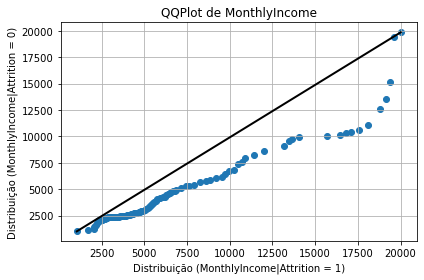

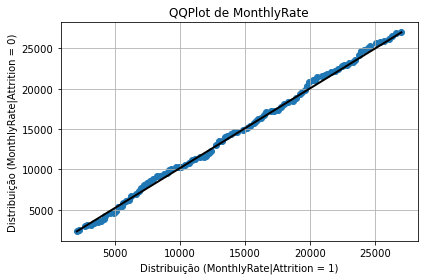

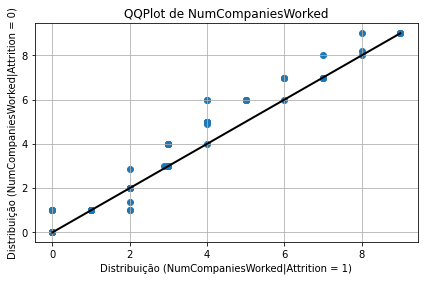

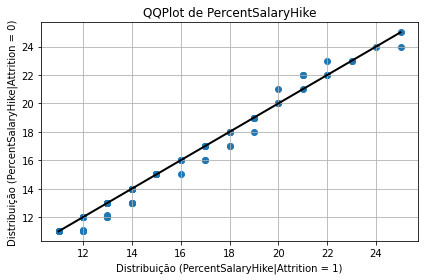

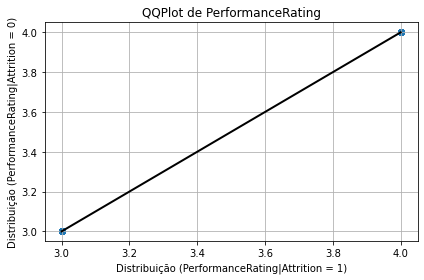

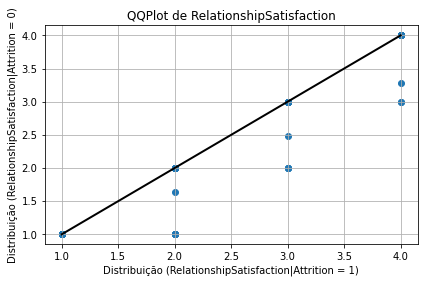

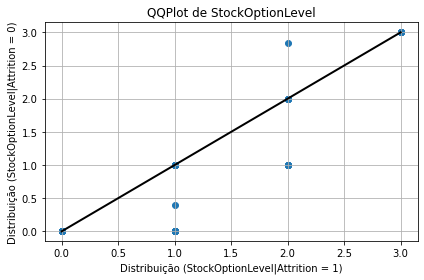

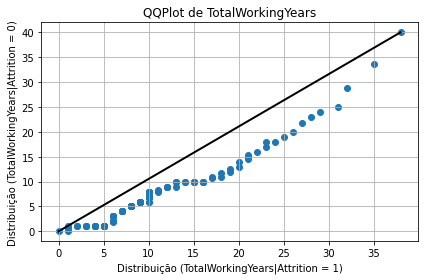

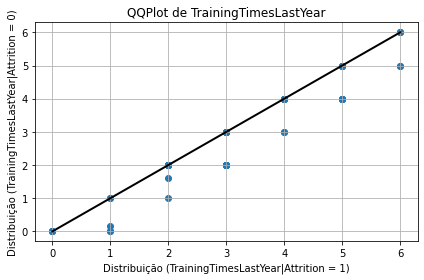

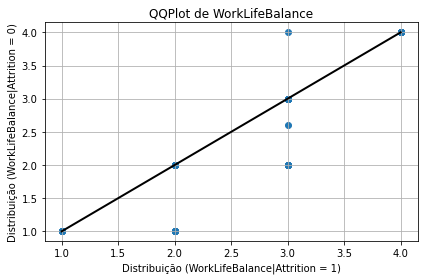

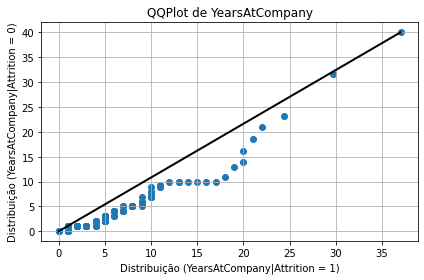

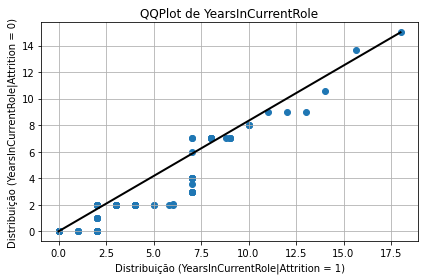

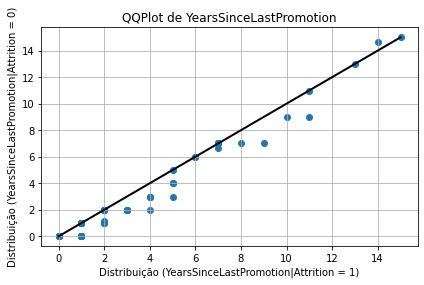

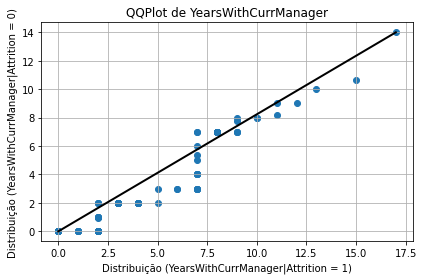

In [31]:
#plotando qqplots
for i in df_num.columns:
    qqplot(i)

As comparações de distribuições do QQPlot apontam que 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany'
apresentam distribuições relevantemente distintas quando condicionais a 'Attrition'.

Também é possível inferir, por outro lado, a semelhança entre distribuições de 'EmployeeNumber','HourlyRate',
'MonthlyRate' e 'PerformanceRating'.

### Preparação para algoritmos

In [33]:
#criando dummies sem uma categoria
df_dummies = pd.get_dummies(df_cat, drop_first=True)

#criando dataframe de variáveis independetes com escala original
X = pd.concat([df_num, df_dummies], axis=1)
X.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,1,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,49,279,8,1,2,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,37,1373,2,2,4,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1
3,33,1392,3,4,5,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
4,27,591,2,1,7,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [34]:
def treino_teste(X):
    '''
    OBJETIVO:
    Separar os dados de treino e teste em apenas uma linha considerando a
    (1) proporção e (2) random state definidos globalmente e (3) de forma
    estratificada.
    
    RESULTADO:
    Dados segregados em treino e teste.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X
                                                        , df['Attrition']
                                                        , test_size=TEST_SIZE
                                                        , random_state = SEED
                                                        , shuffle=True
                                                        , stratify = df['Attrition']                                                     
                                                       )
    return X_train, X_test, y_train, y_test

In [35]:
def metric(model, X_test, y_test, y_pred, beta): 
    '''
    OBJETIVO:
    Método de avaliação do modelo em relação aos acertos e erros.
    
    PARÂMETRO:
    beta: calibragem do Fscore na composição do peso entre 
    precisão e sensibilidade.
    
    RESULTADO:
    Print das métricas.
    '''
    
    #positivo: Attrition = 1
    #negativo: Attrition = 0
    tp = int(sum((y_test == 1) & (y_pred == 1)))
    fp = int(sum((y_test == 0) & (y_pred == 1)))
    tn = int(sum((y_test == 0) & (y_pred == 0)))
    fn = int(sum((y_test == 1) & (y_pred == 0)))
    
    accur = round((tp + tn)/(tp + fp + tn + fn), 3)
    prec = round(tp/(tp + fp + 1e-10), 3)
    recall = round(tp/(tp + fn + 1e-10), 3)

    Fscore = round((1 + beta**2) * prec * recall/(beta ** 2 * prec + recall + 1e-10), 3)
    
    print(model)
    print(f'Accuracy: {accur}')
    print(f'Precision: {prec}')
    print(f'Recall: {recall}')
    print(f'F-Score: {Fscore}')
    
    #plotar matriz de confusão
    array = [[tp, fn],
             [fp, tn]]
    df_matrix = pd.DataFrame(array
                             ,index=['y = 1','y = 0']
                             ,columns=['ŷ = 1','ŷ = 0']
                            )
    fig = sns.heatmap(df_matrix
                    , annot=True
                    , fmt='g'
                    , cmap=sns.diverging_palette(220, 20, as_cmap=True)
                    , square=True
                   )
    fig.set(title='Matriz de Confusão')
    fig2 = fig.get_figure()
    fig2.savefig('matrix_conf')
    plt.show()

In [36]:
def plot_roc_curve(y_test, yhat):
    '''
    OBJETIVO:
    Avaliação da variação da taxa de positivo verdadeiro e taxa de falso
    positivo, condicional a alterações no limiar de probabilidade da 
    variável dependente.
    
    RESULTADO:
    Curva ROC e valor de AUC.
    '''       
    fpr, tpr, _ = roc_curve(y_test, yhat)
    
    auc_value = roc_auc_score(y_test, yhat)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (AUC = %0.2f)' % auc_value)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [82]:
def reg_log(X_train, X_test, y_train, y_test, limiar, beta):
    '''
    OBJETIVO:
    Concentrar o processo de preparação do dado, execução do modelo e
    metrificação dos resultados.
    
    PARÂMETROS
    - limiar: percentual de probabilidade de transição entre variável
    independente 1 ou 0.
    - beta: calibragem do Fscore na composição do peso entre 
    precisão e sensibilidade.
    
    RESULTADO:
    Modelo de regressão logística treinado e testado, e sua avaliação.
    '''      
    #Regressão logística
    logit = sm.Logit(y_train,X_train).fit(maxiter=100)
            
    #'Attrition' estimado
    yhat = logit.predict(X_test)
    yhat.where(yhat > LIMIAR, 0, inplace=True)
    yhat.where(yhat < LIMIAR, 1, inplace=True) 

    #avaliando a regressão logística
    metric(logit, X_test, y_test, yhat, BETA)

    #ROC e AUC
    plot_roc_curve(y_test, yhat)
    
    print(logit.summary())

### Regressão Logística

Optimization terminated successfully.
         Current function value: 0.283571
         Iterations 9
Accuracy: 0.857
Precision: 0.593
Recall: 0.34
F-Score: 0.372


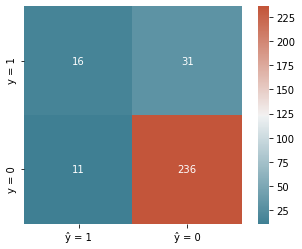

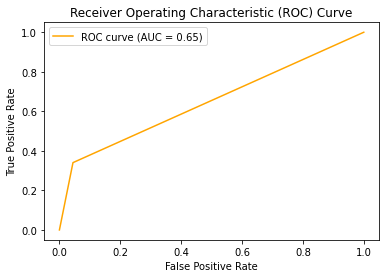

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1131
Method:                           MLE   Df Model:                           44
Date:                Sun, 07 Mar 2021   Pseudo R-squ.:                  0.3588
Time:                        20:21:13   Log-Likelihood:                -333.48
converged:                       True   LL-Null:                       -520.09
Covariance Type:            nonrobust   LLR p-value:                 9.733e-54
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age                                  -0.0448      0.016     -2.765      0.006      -0.077      -0.013
DailyRate                            -0.0005      0.000     -1

In [83]:
#Simulaçao 1: regressão logística + dados completos + desbalanceamento
X_train, X_test, y_train, y_test = treino_teste(X)
reg_log(X_train, X_test, y_train, y_test, LIMIAR, BETA)

Optimization terminated successfully.
         Current function value: 0.441395
         Iterations 7
Accuracy: 0.772
Precision: 0.381
Recall: 0.681
F-Score: 0.588


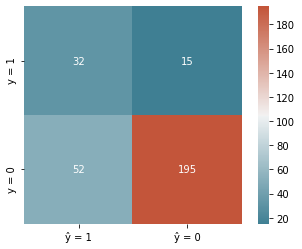

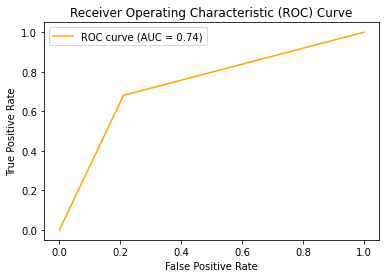

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1972
Model:                          Logit   Df Residuals:                     1927
Method:                           MLE   Df Model:                           44
Date:                Sun, 07 Mar 2021   Pseudo R-squ.:                  0.3632
Time:                        20:21:13   Log-Likelihood:                -870.43
converged:                       True   LL-Null:                       -1366.9
Covariance Type:            nonrobust   LLR p-value:                2.069e-179
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age                                  -0.0214      0.009     -2.312      0.021      -0.039      -0.003
DailyRate                            -0.0006      0.000     -4

In [84]:
#Simulação 2: regressão logística + dados completos + rebalanceamento (over)

X_train, X_test, y_train, y_test = treino_teste(X)

#oversampling
over = RandomOverSampler(random_state=SEED)
X_train_over, y_train_over = over.fit_sample(X_train, y_train)

reg_log(X_train_over, X_test, y_train_over, y_test, LIMIAR, BETA)

Optimization terminated successfully.
         Current function value: 0.415748
         Iterations 7
Accuracy: 0.724
Precision: 0.319
Recall: 0.638
F-Score: 0.532


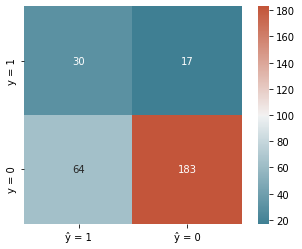

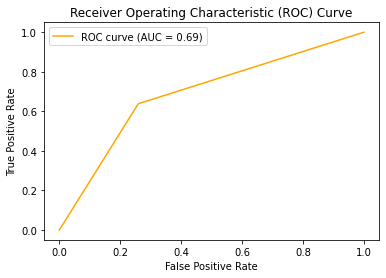

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                  380
Model:                          Logit   Df Residuals:                      335
Method:                           MLE   Df Model:                           44
Date:                Sun, 07 Mar 2021   Pseudo R-squ.:                  0.4002
Time:                        20:21:14   Log-Likelihood:                -157.98
converged:                       True   LL-Null:                       -263.40
Covariance Type:            nonrobust   LLR p-value:                 1.224e-23
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age                                  -0.0076      0.023     -0.333      0.739      -0.052       0.037
DailyRate                            -0.0008      0.000     -2

In [85]:
#Simulação 3: regressão logística + dados completos + rebalanceamento (under)

X_train, X_test, y_train, y_test = treino_teste(X)

#undersampling
under = RandomUnderSampler(random_state=SEED)
X_train_under, y_train_under = under.fit_sample(X_train, y_train)

reg_log(X_train_under, X_test, y_train_under, y_test, LIMIAR, BETA)

Optimization terminated successfully.
         Current function value: 0.296928
         Iterations 8
Accuracy: 0.864
Precision: 0.64
Recall: 0.34
F-Score: 0.375


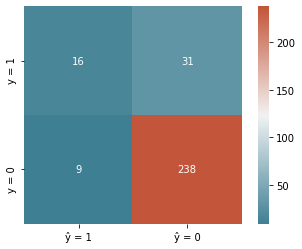

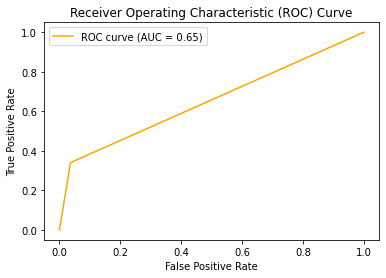

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1139
Method:                           MLE   Df Model:                           36
Date:                Sun, 07 Mar 2021   Pseudo R-squ.:                  0.3286
Time:                        20:21:14   Log-Likelihood:                -349.19
converged:                       True   LL-Null:                       -520.09
Covariance Type:            nonrobust   LLR p-value:                 1.690e-51
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
DailyRate                            -0.0005      0.000     -2.140      0.032      -0.001   -4.42e-05
DistanceFromHome                      0.0490      0.012      4

In [86]:
#Simulação 4: regressão logística + dados com baixa correlação + desbalanceados
X_uncor = X.drop(columns=[
                              #variáveis correlacionadas de tempo  
                              'Age'
                              #,'TotalWorkingYears'
                              ,'JobLevel'
                              ,'MonthlyIncome'
                              ,'YearsAtCompany'
                              ,'YearsInCurrentRole'
                              ,'YearsSinceLastPromotion'
                              ,'YearsWithCurrManager'

                              #variáveis correlacionadas a promoção
                              #,'PercentSalaryHike'
                              ,'PerformanceRating'
                             ]
                    )

X_train, X_test, y_train, y_test = treino_teste(X_uncor)
reg_log(X_train, X_test, y_train, y_test, LIMIAR, BETA)

Optimization terminated successfully.
         Current function value: 0.456985
         Iterations 7
Accuracy: 0.789
Precision: 0.407
Recall: 0.702
F-Score: 0.613


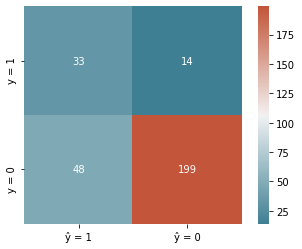

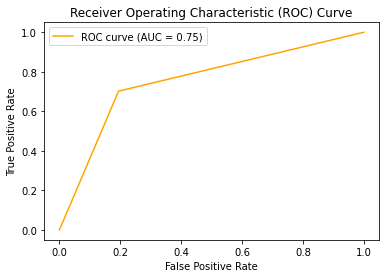

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1972
Model:                          Logit   Df Residuals:                     1935
Method:                           MLE   Df Model:                           36
Date:                Sun, 07 Mar 2021   Pseudo R-squ.:                  0.3407
Time:                        20:21:15   Log-Likelihood:                -901.17
converged:                       True   LL-Null:                       -1366.9
Covariance Type:            nonrobust   LLR p-value:                3.689e-172
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
DailyRate                            -0.0007      0.000     -4.361      0.000      -0.001      -0.000
DistanceFromHome                      0.0434      0.007      5

In [87]:
#Simulação 5: regressão logística + dados com baixa correlação + rebalanceamento (over)

X_train, X_test, y_train, y_test = treino_teste(X_uncor)

#oversampling
over = RandomOverSampler(random_state=SEED)
X_train_over, y_train_over = over.fit_sample(X_train, y_train)

reg_log(X_train_over, X_test, y_train_over, y_test, LIMIAR, BETA)

Optimization terminated successfully.
         Current function value: 0.435753
         Iterations 7
Accuracy: 0.745
Precision: 0.348
Recall: 0.681
F-Score: 0.572


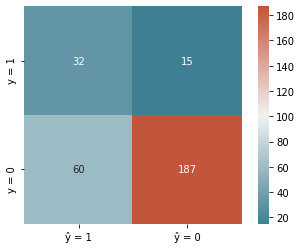

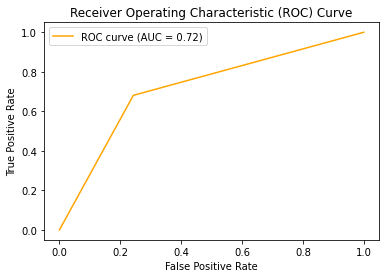

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                  380
Model:                          Logit   Df Residuals:                      343
Method:                           MLE   Df Model:                           36
Date:                Sun, 07 Mar 2021   Pseudo R-squ.:                  0.3713
Time:                        20:21:15   Log-Likelihood:                -165.59
converged:                       True   LL-Null:                       -263.40
Covariance Type:            nonrobust   LLR p-value:                 7.746e-24
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
DailyRate                            -0.0008      0.000     -2.086      0.037      -0.001   -4.54e-05
DistanceFromHome                      0.0554      0.018      3

In [88]:
#Simulação 6: regressão logística + dados com baixa correlação + rebalanceamento (under)

X_train, X_test, y_train, y_test = treino_teste(X_uncor)

#undersampling
under = RandomUnderSampler(random_state=SEED)
X_train_under, y_train_under = under.fit_sample(X_train, y_train)

reg_log(X_train_under, X_test, y_train_under, y_test, LIMIAR, BETA)

LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.854
Precision: 0.75
Recall: 0.128
F-Score: 0.153


/home/rafaelk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


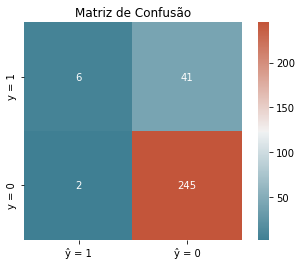

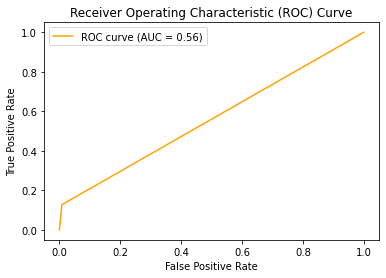

,peso
OverTime_Yes,0.34
YearsSinceLastPromotion,0.23
MaritalStatus_Single,0.21
NumCompaniesWorked,0.16
BusinessTravel_Travel_Frequently,0.16
Department_Sales,0.14
JobRole_Laboratory Technician,0.12
PerformanceRating,0.08
YearsAtCompany,0.08
JobRole_Sales Representative,0.08


In [37]:
#Simulaçao 1: regressão logística (baseline)

#separação em treino e teste
X_train, X_test, y_train, y_test = treino_teste(X)

#regressão logística
model = LogisticRegression(random_state=SEED, max_iter=1000)
model.fit(X_train, y_train)
yhat = model.predict(X_test)

#métricas
metric(model, X_test, y_test, yhat, BETA)

#ROC e AUC
plot_roc_curve(y_test, yhat)

#ranking das variáveis
importance = model.coef_[0]
pd.DataFrame(importance, index=X.columns, columns=['peso']).sort_values('peso', ascending = False)

LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.861
Precision: 0.615
Recall: 0.34
F-Score: 0.373


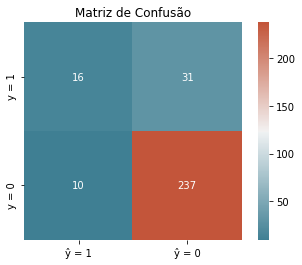

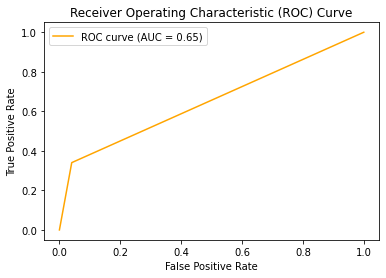

,peso
OverTime_Yes,0.86
BusinessTravel_Travel_Frequently,0.75
JobRole_Laboratory Technician,0.71
YearsSinceLastPromotion,0.53
NumCompaniesWorked,0.49
JobRole_Sales Representative,0.48
BusinessTravel_Travel_Rarely,0.45
JobRole_Sales Executive,0.40
DistanceFromHome,0.39
MaritalStatus_Single,0.37


In [38]:
#Simulaçao 2: regressão logística + standardscaler()

X_train, X_test, y_train, y_test = treino_teste(X)

#padronização
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

model = LogisticRegression(random_state=SEED, max_iter=1000)
model.fit(X_train_std, y_train)
yhat = model.predict(X_test_std)

metric(model, X_test_std, y_test, yhat, BETA)
plot_roc_curve(y_test, yhat)

importance = model.coef_[0]
pd.DataFrame(importance, index=X.columns, columns=['peso']).sort_values('peso', ascending = False)

LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.878
Precision: 0.739
Recall: 0.362
F-Score: 0.403


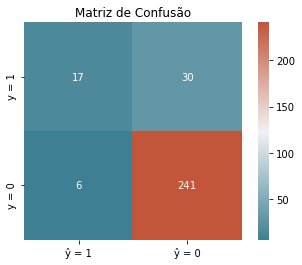

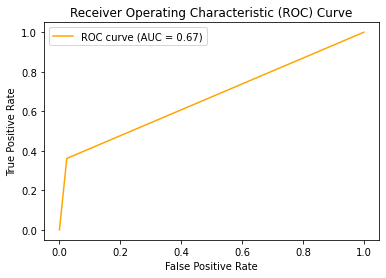

,peso
OverTime_Yes,1.68
YearsSinceLastPromotion,1.57
BusinessTravel_Travel_Frequently,1.45
NumCompaniesWorked,1.34
JobRole_Laboratory Technician,1.26
DistanceFromHome,1.10
JobRole_Sales Representative,0.93
MaritalStatus_Single,0.73
BusinessTravel_Travel_Rarely,0.61
JobRole_Human Resources,0.53


In [39]:
#Simulaçao 3: regressão logística + minmaxscaler()
X_train, X_test, y_train, y_test = treino_teste(X)

#padronização
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

model = LogisticRegression(random_state=SEED, max_iter=1000)
model.fit(X_train_std, y_train)
yhat = model.predict(X_test_std)

metric(model, X_test_std, y_test, yhat, BETA)
plot_roc_curve(y_test, yhat)
    
importance = model.coef_[0]
pd.DataFrame(importance, index=X.columns, columns=['peso']).sort_values('peso', ascending = False)

In [40]:
#removendo dados altamente correlacionados
X_uncor = X.drop(columns=[
                              #variáveis correlacionadas de tempo  
                              'Age'
                              #,'TotalWorkingYears'
                              ,'JobLevel'
                              ,'MonthlyIncome'
                              ,'YearsAtCompany'
                              ,'YearsInCurrentRole'
                              ,'YearsSinceLastPromotion'
                              ,'YearsWithCurrManager'

                              #variáveis correlacionadas a promoção
                              #,'PercentSalaryHike'
                              ,'PerformanceRating'
                             ]
                    )

LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.854
Precision: 0.6
Recall: 0.255
F-Score: 0.288


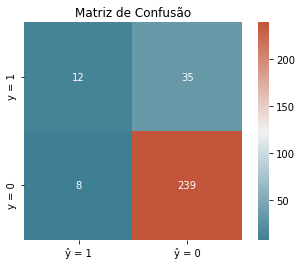

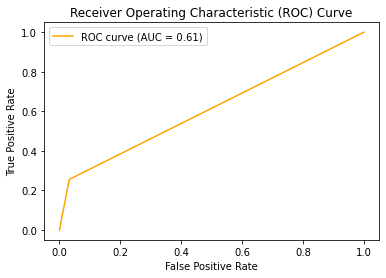

,peso
OverTime_Yes,1.63
BusinessTravel_Travel_Frequently,1.43
JobRole_Laboratory Technician,1.31
NumCompaniesWorked,1.21
JobRole_Sales Representative,1.12
DistanceFromHome,1.10
MaritalStatus_Single,0.71
BusinessTravel_Travel_Rarely,0.61
JobRole_Human Resources,0.53
Department_Sales,0.32


In [41]:
#Simulaçao 4: regressão logística + minmaxscaler() + dados com baixa correlação

#dados com caixa correlação
X_train, X_test, y_train, y_test = treino_teste(X_uncor)

scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

model = LogisticRegression(random_state=SEED, max_iter=1000)
model.fit(X_train_std, y_train)
yhat = model.predict(X_test_std)

metric(model, X_test_std, y_test, yhat, BETA)
plot_roc_curve(y_test, yhat)

importance = model.coef_[0]
pd.DataFrame(importance, index=X_uncor.columns, columns=['peso']).sort_values('peso', ascending = False)

LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.786
Precision: 0.4
Recall: 0.681
F-Score: 0.597


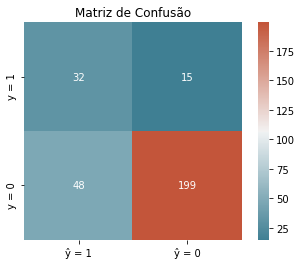

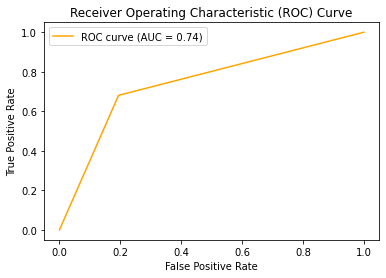

,peso
YearsSinceLastPromotion,1.81
NumCompaniesWorked,1.76
OverTime_Yes,1.68
BusinessTravel_Travel_Frequently,1.54
JobRole_Laboratory Technician,1.15
DistanceFromHome,1.14
JobRole_Sales Representative,1.05
BusinessTravel_Travel_Rarely,0.77
MaritalStatus_Single,0.74
Department_Sales,0.67


In [42]:
#Simulaçao 5: regressão logística + minmaxscaler() + dados originais + oversampler

X_train, X_test, y_train, y_test = treino_teste(X)

scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

#rebalanceamento dos dados
over = RandomOverSampler(random_state=SEED)
X_train_std_over, y_train_over = over.fit_sample(X_train_std, y_train)

model = LogisticRegression(random_state=SEED, max_iter=1000)
model.fit(X_train_std_over, y_train_over)

yhat = model.predict(X_test_std)
metric(model, X_test_std, y_test, yhat, BETA)
plot_roc_curve(y_test, yhat)

importance = model.coef_[0]
pd.DataFrame(importance, index=X.columns, columns=['peso']).sort_values('peso', ascending = False)

LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.796
Precision: 0.418
Recall: 0.702
F-Score: 0.618


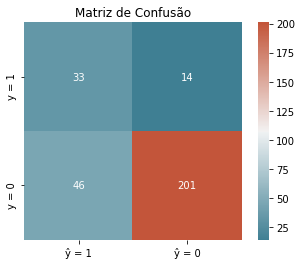

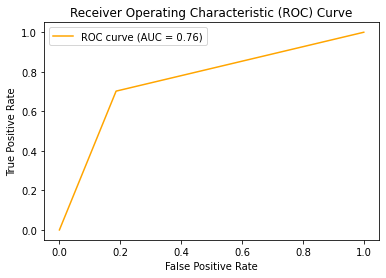

,peso
OverTime_Yes,1.70
NumCompaniesWorked,1.68
BusinessTravel_Travel_Frequently,1.51
JobRole_Sales Representative,1.19
DistanceFromHome,1.13
JobRole_Laboratory Technician,1.11
BusinessTravel_Travel_Rarely,0.71
MaritalStatus_Single,0.71
Department_Sales,0.66
JobRole_Human Resources,0.59


In [44]:
#Simulaçao 6: regressão logística + minmaxscaler() + dados com baixa correlação + oversampler

#dados com baixa correlação
X_train, X_test, y_train, y_test = treino_teste(X_uncor)

scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

over = RandomOverSampler(random_state=SEED)
X_train_std_over, y_train_over = over.fit_sample(X_train_std, y_train)

model = LogisticRegression(random_state=SEED, max_iter=1000)
model.fit(X_train_std_over, y_train_over)

yhat = model.predict(X_test_std)
metric(model, X_test_std, y_test, yhat, BETA)
plot_roc_curve(y_test, yhat)

importance = model.coef_[0]
pd.DataFrame(importance, index=X_uncor.columns, columns=['peso']).sort_values('peso', ascending = False)

LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.762
Precision: 0.368
Recall: 0.681
F-Score: 0.582


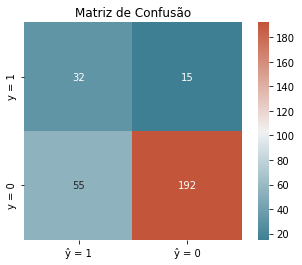

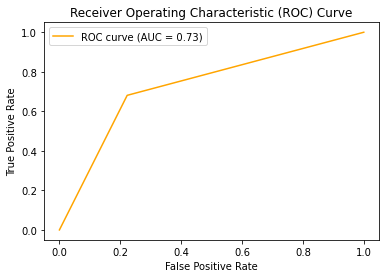

,peso
OverTime_Yes,1.38
BusinessTravel_Travel_Frequently,1.32
JobRole_Laboratory Technician,1.14
NumCompaniesWorked,1.13
DistanceFromHome,1.07
MaritalStatus_Single,1.00
EducationField_Technical Degree,0.71
YearsSinceLastPromotion,0.68
JobRole_Sales Representative,0.64
BusinessTravel_Travel_Rarely,0.63


In [47]:
#Simulaçao 7: regressão logística + minmaxscaler() + dados originais + undersampler

#dados com baixa correlação
X_train, X_test, y_train, y_test = treino_teste(X)

scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

over = RandomUnderSampler(random_state=SEED)
X_train_std_under, y_train_under = over.fit_sample(X_train_std, y_train)

model = LogisticRegression(random_state=SEED, max_iter=1000)
model.fit(X_train_std_under, y_train_under)

yhat = model.predict(X_test_std)
metric(model, X_test_std, y_test, yhat, BETA)
plot_roc_curve(y_test, yhat)

importance = model.coef_[0]
pd.DataFrame(importance, index=X.columns, columns=['peso']).sort_values('peso', ascending = False)

LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.755
Precision: 0.36
Recall: 0.681
F-Score: 0.578


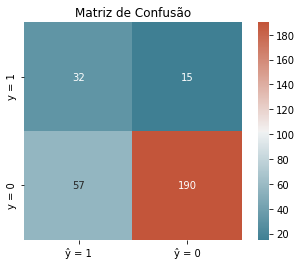

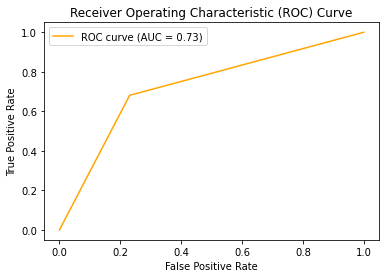

,peso
OverTime_Yes,1.36
BusinessTravel_Travel_Frequently,1.30
JobRole_Laboratory Technician,1.25
NumCompaniesWorked,1.15
DistanceFromHome,1.09
MaritalStatus_Single,1.00
JobRole_Sales Representative,0.82
EducationField_Technical Degree,0.73
BusinessTravel_Travel_Rarely,0.62
MonthlyRate,0.56


In [48]:
#Simulaçao 8: regressão logística + minmaxscaler() + dados com baixa correlação + undersampler

#dados com baixa correlação
X_train, X_test, y_train, y_test = treino_teste(X_uncor)

scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

over = RandomUnderSampler(random_state=SEED)
X_train_std_under, y_train_under = over.fit_sample(X_train_std, y_train)

model = LogisticRegression(random_state=SEED, max_iter=1000)
model.fit(X_train_std_under, y_train_under)

yhat = model.predict(X_test_std)
metric(model, X_test_std, y_test, yhat, BETA)
plot_roc_curve(y_test, yhat)

importance = model.coef_[0]
pd.DataFrame(importance, index=X_uncor.columns, columns=['peso']).sort_values('peso', ascending = False)

##### Conclusão
A simulação 6 apresentou o melhor FScore dos modelos acima (0,618), considerando um Beta = 2 priorizando a sensibilidade dos dados em detrimento da precisão.

As variáveis mais influentes para Attrition foram: TotalWorkingYears (influência negativa) e OverTime_Yes (influência positivo)

